# Grad-CAM for Models with mixed layers

In [90]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import datetime
import cv2

In [91]:
%load_ext tensorboard.notebook

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


## Making the images

In [92]:
class_zero_template = np.zeros((32,32))

In [93]:
class_zero_template = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

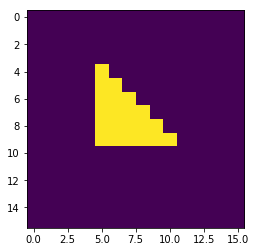

In [94]:
plt.imshow(class_zero_template)

In [95]:
class_one_template = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                                [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

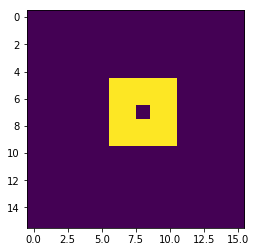

In [96]:
plt.imshow(class_one_template)

In [97]:
class_one_template.shape

(16, 16)

#### Now we introduce some 'random noise', essentially switching a fixed number of pixels within our 16x16 map to 0

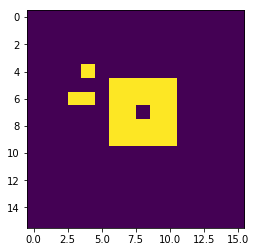

In [98]:
def generate_noise(input_img, num_of_pixels):
    idx1_arr = np.random.randint((input_img.shape[0]-1), size=num_of_pixels)
    idx2_arr = np.random.randint((input_img.shape[1]-1), size=num_of_pixels)
    out_img = np.copy(input_img)
    for i, j in zip(idx1_arr, idx2_arr):
        out_img[i][j] = 1
    return out_img

def image_generator(input_img, pixel_noise):
    while True:
        yield generate_noise(input_img, pixel_noise)

plt.imshow(generate_noise(class_one_template, 3))

# Generating data for the training and validation

In [99]:
class_zero_generator = image_generator(class_zero_template, 3)
class_one_generator = image_generator(class_one_template, 3)

# initialize those as None to make conditionals work in the loops
class_zero_train = None
class_zero_test = None
class_one_train = None
class_one_test = None

# roughly 80/20 split
train_size = 64
test_size = 13
for i in range(train_size):
    if class_zero_train is not None:
        class_zero_train = np.append(class_zero_train, np.expand_dims(next(class_zero_generator), axis=0), axis=0)
    else:
        class_zero_train = np.expand_dims(next(class_zero_generator), axis=0)
    if class_one_train is not None:
        class_one_train = np.append(class_one_train, np.expand_dims(next(class_one_generator), axis=0), axis=0)
    else: 
        class_one_train = np.expand_dims(next(class_one_generator), axis=0)

class_zero_labels = np.zeros(train_size)
class_one_labels = np.ones(train_size)

x_train = np.append(class_zero_train, class_one_train, axis=0)
y_train = np.append(class_zero_labels, class_one_labels)
    
for i in range(test_size):
    if class_zero_test is not None:
        class_zero_test = np.append(class_zero_test, np.expand_dims(next(class_zero_generator), axis=0), axis=0)
    else:
        class_zero_test = np.expand_dims(next(class_zero_generator), axis=0)
    if class_one_test is not None:
        class_one_test = np.append(class_one_test, np.expand_dims(next(class_one_generator), axis=0), axis=0)
    else:
        class_one_test = np.expand_dims(next(class_one_generator), axis=0)
    
class_zero_labels = np.zeros(test_size)
class_one_labels = np.ones(test_size)

x_test = np.append(class_zero_test, class_one_test, axis=0)
y_test = np.append(class_zero_labels, class_one_labels)

In [100]:
x_train.shape

(128, 16, 16)

In [101]:
y_train.shape

(128,)

In [102]:
x_test.shape

(26, 16, 16)

In [103]:
y_test.shape

(26,)

In [104]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

# taken from: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison  mrtw's answer

In [105]:
x_train, y_train = unison_shuffled_copies(x_train, y_train)
x_test, y_test = unison_shuffled_copies(x_test, y_test)

#### Let's try to visualize a few examples from the training set

In [106]:
x_train.shape

(128, 16, 16)

In [107]:
def show_something(dataset, labels, index):
    plt.imshow(x_train[index,:,:])
    print("label for this image is: {}".format(labels[index]))

label for this image is: 0.0


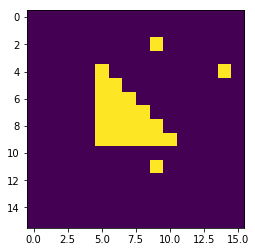

In [108]:
show_something(x_train, y_train, np.random.randint(len(y_train)-1))  # this shows a random image from the training dataset

#### Now we expand dimensions to stay consistent with NWHC, so we need to expand axis -1 (last one)

In [109]:
np.expand_dims(x_train, axis=-1).shape

(128, 16, 16, 1)

In [110]:
x_train = np.expand_dims(x_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)

x_test = np.expand_dims(x_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

# Creating the model

Let's create a model in which we will redirect output to two different conv layers and concatenate output right before feeding it into dense layers.

In [111]:
x = tf.keras.layers.Input(shape=(16,16,1))
x1 = tf.keras.layers.Conv2D(64, (3, 3), input_shape=(16, 16, 1), activation='relu')(x)
x1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(x1)
x2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), padding='same')(x2)
x1 = tf.keras.layers.Flatten()(x1)
x2 = tf.keras.layers.Flatten()(x2)
y = tf.keras.layers.Concatenate()([x1, x2])
y = tf.keras.layers.Dense(16, activation='relu')(y)
y = tf.keras.layers.Dense(1, activation='sigmoid')(y)
model = tf.keras.models.Model(inputs=x, outputs=y)

In [112]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 14, 14, 64)   640         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 14, 14, 64)   640         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 7, 7, 64)     0           conv2d_13[0][0]                  
____________________________________________________________________________________________

In [113]:
model.layers[7].name

'concatenate_2'

In [114]:
for i in range(len(model.layers)):
    print(model.get_layer(model.layers[i].name).outbound_nodes)
    print(i)

[<tensorflow.python.keras.engine.base_layer.Node object at 0x11189e908>, <tensorflow.python.keras.engine.base_layer.Node object at 0x13b2d8c88>]
0
1
2
3
4
5
6
7
8
[]
9


In [115]:
model.get_layer(model.layers[0].name).inbound_nodes[0].get_config()

{'outbound_layer': 'input_8',
 'inbound_layers': [],
 'node_indices': [],
 'tensor_indices': []}

In [116]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.1), loss='binary_crossentropy', metrics=['accuracy'])

In [117]:
model.fit(x=x_train,
          y=y_train, 
          epochs=20, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Train on 128 samples, validate on 26 samples
Epoch 1/20
128/128 [==============================] - 0s 4ms/sample - loss: 0.6858 - accuracy: 0.5078 - val_loss: 0.6874 - val_accuracy: 0.5000
Epoch 2/20
128/128 [==============================] - 0s 375us/sample - loss: 0.6830 - accuracy: 0.5078 - val_loss: 0.6845 - val_accuracy: 0.5000
Epoch 3/20
128/128 [==============================] - 0s 541us/sample - loss: 0.6800 - accuracy: 0.5156 - val_loss: 0.6814 - val_accuracy: 0.5000
Epoch 4/20
128/128 [==============================] - 0s 388us/sample - loss: 0.6767 - accuracy: 0.5469 - val_loss: 0.6782 - val_accuracy: 0.5000
Epoch 5/20
128/128 [==============================] - 0s 369us/sample - loss: 0.6735 - accuracy: 0.5625 - val_loss: 0.6751 - val_accuracy: 0.5000
Epoch 6/20
128/128 [==============================] - 0s 454us/sample - loss: 0.6704 - accuracy: 0.6016 - val_loss: 0.6722 - val_accuracy: 0.5385
Epoch 7/20
128/128 [==============================] - 0s 420us/sample - loss: 0.6

# Let's start tracing back the gradients

### First we need a sample image to make predictions on

In [232]:
im = next(image_generator(class_zero_template, 3))

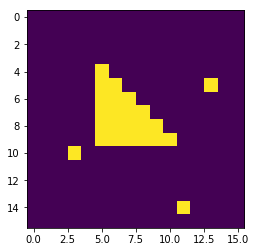

In [233]:
plt.imshow(im)

In [234]:
im.reshape(1, *im.shape, 1).shape

(1, 16, 16, 1)

In [235]:
model.predict(im.reshape(1, *im.shape, 1))  # prediction value

array([[0.45783487]], dtype=float32)

In [236]:
model(tf.cast(im.reshape(1, *im.shape, 1), tf.float32))  # also a prediction value but using `call` instead of `predict`
# this returns a tf.Tensor

<tf.Tensor: id=9113, shape=(1, 1), dtype=float32, numpy=array([[0.45783487]], dtype=float32)>

#### We can use GradientTape to trace gradient values
Let's calculate the MSE for this particular predition

In [237]:
with tf.GradientTape() as tape:
    error = model(tf.cast(im.reshape(1, *im.shape, 1), tf.float32)) - 0 # NOT model.predict(x) - y
    loss_value = tf.reduce_mean(tf.square(error))
gradients = tape.gradient(loss_value, model.variables)

`model.variables` is where kernels and biases live

In [238]:
print([i.name for i in model.variables])

['conv2d_13/kernel:0', 'conv2d_13/bias:0', 'conv2d_14/kernel:0', 'conv2d_14/bias:0', 'dense_5/kernel:0', 'dense_5/bias:0', 'dense_6/kernel:0', 'dense_6/bias:0']


We can create thus a list of all kernels and biases associated with any **convolutional layers** we have in our model and put it in a list (`A_k`).

Two outbound nodes of the input layer point to two different convolutional layers,

In [239]:
model.get_layer(model.layers[0].name).outbound_nodes[0].get_config()

{'outbound_layer': 'conv2d_13',
 'inbound_layers': 'input_8',
 'node_indices': 0,
 'tensor_indices': 0}

In [240]:
model.get_layer(model.layers[0].name).outbound_nodes[1].get_config()

{'outbound_layer': 'conv2d_14',
 'inbound_layers': 'input_8',
 'node_indices': 0,
 'tensor_indices': 0}

In [241]:
class tuple_dict(dict):
    def __init__(self, *args):
        dict.__init__(self, args)

    def __getitem__(self, i):
        if type(i) == tuple:
            lst = []
            for n in i:
                lst.append(dict.__getitem__(self, n))
            return lst
        elif type(i) == str:
            return dict.__getitem__(self, i)

In [242]:
d_test = tuple_dict()
d_test['a']=1
d_test['b']=2
d_test['c']=3

In [243]:
d_test[('a', 'b')]

[1, 2]

In [244]:
def get_outputs_at_each_layer(model, input_image, layer_type):
    """
    make it robust to weird connections between layers
    """
    with tf.GradientTape() as tape:
        outputs = tuple_dict()
        current_output = model.get_layer(model.layers[0].name)(input_image)
        outputs[model.layers[0].name] = current_output
        restricted_outputs = []
        for i in model.layers[:]:
    #         out = model.get_layer(i.name)(out)
    # input points to two outbound nodes: two different conv layers
    # inbound_node in config gets the input node
    # outbound_node in config points to the operation
    # so in our case inbound: input layer, outbound: conv layer
    # and the other node is: input layer, second conv layer
    # try using node objects as dict keys where you record outputs
    # change outputs list into a dict
            outbound_nodes = model.get_layer(i.name).outbound_nodes
            inbound_nodes = model.get_layer(i.name).inbound_nodes
            for n in outbound_nodes:
                config = n.get_config()
#                 outputs[config['outbound_layer']] = model.get_layer(config['outbound_layer'])(model.get_layer(config['inbound_layers']))
                #(outputs[config['inbound_layers']]))
#                 print(config['inbound_layers'])
#                 print(config['outbound_layer'])
#                 if type(config['outbound_layer']) == list:
#                     for m in config['outbound_layer']:
#                         outputs[m] = model.get_layer(m)(outputs[config['inbound_layers']])
#                 elif type(config['inbound_layers']) == list:
#                     for m in config['inbound_layers']:
#                         outputs[config['outbound_layer']] = model.get_layer(config['outbound_layer'])(outputs[m])
#                 else:
                
#                 def inner(outputs, ibl, obl):
#                     if type(ibl) == tuple:
#                     if type(obl) == tuple:
#                         for i in outputs[ibl]
#                         outputs[obl] = model.get_layer(obl)(outputs[ibl])
#                     else:
#                         outputs[obl] = model.get_layer(obl)(outputs[ibl])
#                     else:
#                         outputs[obl] = model.get_layer(obl)(outputs[ibl])
#                     return outputs
                if type(config['outbound_layer']) == list:
                    obl = tuple(config['outbound_layer'])
                else:
                    obl = config['outbound_layer']
                if type(config['inbound_layers']) == list:
                    ibl = tuple(config['inbound_layers'])
                else:
                    ibl = config['inbound_layers']
                out = model.get_layer(obl)(outputs[ibl])
                outputs[obl] = out
                if layer_type in i.name:
                    restricted_outputs.append(outputs[obl])
    gradients = tape.gradient(out, restricted_outputs)
    return restricted_outputs, gradients

In [245]:
A_k, dy_dA_k = get_outputs_at_each_layer(model, tf.cast(im.reshape(1, *im.shape, 1), tf.float32), 'conv')

In [246]:
for i in dy_dA_k:
    print(i.shape)

(1, 7, 7, 64)
(1, 7, 7, 64)


In [247]:
for i in A_k:
    print(i.shape)

(1, 7, 7, 64)
(1, 7, 7, 64)


In [248]:
# A_k = [i for i in model.variables if (('conv' in i.name) and ('kernel' in i.name))]
# print([i.name for i in A_k])

In [249]:
# with tf.GradientTape() as g:
#     error = model(tf.cast(im.reshape(1, *im.shape, 1), tf.float32)) - 0 # NOT model.predict(x) - y
#     loss_value = tf.reduce_mean(tf.square(error))
# dy_dA_k = g.gradient(loss_value, A_k)

In [250]:
# with tf.GradientTape() as tape:
#     error = model(tf.cast(im.reshape(1, *im.shape, 1), tf.float32)) - 0 # NOT model.predict(x) - y
#     loss_value = tf.reduce_mean(tf.square(error))
# gradients = tape.gradient(loss_value, model.variables)

In [251]:
# with tf.GradientTape() as g:
#     error = model(tf.cast(im.reshape(1, *im.shape, 1), tf.float32)) # NOT model.predict(x) - y
#     feature_maps = get_outputs_at_each_layer(model, tf.cast(im.reshape(1, *im.shape, 1), tf.float32), 'conv')
    
# dy_dA_k = g.gradient(loss_value, A_k)

In [252]:
print(dy_dA_k[0].shape)

(1, 7, 7, 64)


# Grad-CAM

Having the derivative of loss function with respect to each conv kernel, we can now try to implement Grad-CAM from scratch

**The process is as follows**:

1. Compute gradient of scores for class `c` with respect to collected feature maps of a convolutional layer.
    
    $\large \frac{(\delta y^c)}{(\delta A^k)}$
    
2. Run Global Average Pooling on that gradient to obtain importance weights of each feature map.

    $\large \alpha^c_k = \frac{1}{Z} \Sigma_{i} \Sigma_{j} \frac{(\delta y^c)}{(\delta A^k)}$
    
3. Compute Grad-CAM $L^c$ function

    $\large L^c = ReLU(\Sigma_{k} \alpha^c_k A^k)$
    
    Here we use the ReLU to look only at pixels whose value actually contribute to the increase of $y^c$ scores
    
4. We upsample $L^c$ using bilinear interpolation method...

5. ... and finally perform pixel-wise multiplication with the guided backpropagation results.

In [253]:
gap = [tf.keras.layers.GlobalAveragePooling2D()(i) for i in dy_dA_k]
np.array(gap).shape  # thus each alpha_k is an element of the 'gap' list

(2, 1, 64)

In [254]:
print(dy_dA_k[0].shape)
# print(dy_dA_k[1].shape)

(1, 7, 7, 64)


So we have two gradient tensors, first corresponding to the first layer which had `3x3` kernel size and the second corresponding to the `1x1` kernel. The last dimension is the actual number of feature maps within the tensor.

In [255]:
print(A_k[0].shape)
# print(A_k[1].shape)

(1, 7, 7, 64)


Shapes of the A_k elements are the same.

In [256]:
tf.math.multiply(dy_dA_k[0], A_k[0]).shape

TensorShape([1, 7, 7, 64])

In [257]:
L_c_0 = tf.keras.layers.ReLU()(tf.math.reduce_sum(tf.math.multiply(dy_dA_k[0], A_k[0]), axis=3))

In [258]:
L_c_0.shape

TensorShape([1, 7, 7])

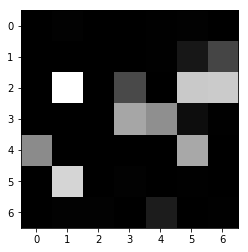

In [259]:
plt.imshow(L_c_0[0, :, :], cmap='gray')

In [260]:
# def unpack_maps(A_k, layer_idx):
#     new_shape = list(A_k[layer_idx].shape)
#     new_shape = [new_shape[-1]] + new_shape[:-1]
#     yield tf.reshape(A_k[layer_idx], new_shape).numpy()

In [261]:
# plt.imshow(test[1, 1, :, :], cmap='gray')

#### We pick one of three saliency maps and scale it down to original image size

In [262]:
test = L_c_0.numpy()

In [263]:
test.shape

(1, 7, 7)

In [264]:
def upsample_array(arr, final_shape):
    integer_div= []
    modulo = []
    out = np.copy(arr)
    assert len(final_shape) == len(arr.shape), "Output shape has to have same number of dims!"
    for i in range(len(arr.shape)):
        integer_div.append(final_shape[i]//arr.shape[i])
        modulo.append(final_shape[i]%arr.shape[i])
    if len(modulo) != 0:
        integer_div = [i+1 for i in integer_div]
    for idx, i in enumerate(integer_div):
        out = out.repeat(i, axis=idx)
    if out.shape != final_shape:
        start = [None for i in range(len(final_shape))]
        end = final_shape
        zipped = tuple(zip(start, final_shape))
        slices = tuple([slice(i[0], i[1]) for i in zipped])
        out = out[slices]
    return out

In [265]:
upsample_array(test[0, :, :], (16, 16)).shape

(16, 16)

In [266]:
test.shape

(1, 7, 7)

In [267]:
test_test = upsample_array(test[0, :, :], (16, 16))
test_test = Image.fromarray(test_test)
np.array(test_test).shape

(16, 16)

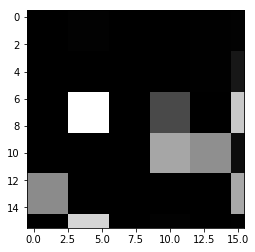

In [268]:
plt.imshow(test_test, cmap='gray')

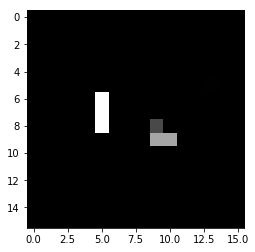

In [269]:
plt.imshow(im*test_test, cmap='gray')

#### Now we can make a heatmap of features that have been detected

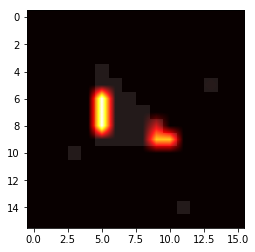

In [270]:
plt_im1 = plt.imshow(im, cmap=plt.cm.gray, interpolation='nearest')

plt_im2 = plt.imshow(test_test*im, cmap=plt.cm.hot, alpha=.9, interpolation='bilinear')

plt.show()